# Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
pip install "flaml[automl]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.2/295.2 kB 6.2 MB/s eta 0:00:00


In [19]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, learning_curve,ShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,get_scorer_names
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold,cross_validate
from flaml import AutoML
import matplotlib.pyplot as plt
from flaml.automl.ml import sklearn_metric_loss_score
from flaml.automl.data import get_output_from_log
import pickle


In [5]:
rel_path = "/content/drive/MyDrive/clean_data_final.csv"
df = pd.read_csv(rel_path)


In [6]:
# Explore the Data
print("Head of the dataset:")
print(df.head())


Head of the dataset:
   TRAIN_SERVICE_CODE_AFFECTED SERVICE_GROUP_CODE_AFFECTED ENGLISH_DAY_TYPE  \
0                     22215003                        EK03               BH   
1                     22215003                        EK03               BH   
2                     22218000                        EK99               BH   
3                     22218000                        EK99               BH   
4                     22218000                        EK99               BH   

  APP_TIMETABLE_FLAG_AFF  UNIT_CLASS_AFFECTED INCIDENT_REASON  \
0                      Y                375.0               M   
1                      Y                375.0               M   
2                      Y                375.0               M   
3                      Y                375.0               M   
4                      Y                375.0               M   

  PERFORMANCE_EVENT_CODE  PFPI_MINUTES    Lat_OR   Lon_OR  ...  \
0                      M           9.0  51.5465

In [7]:
print("NANs:")
df.isnull().mean()

NANs:


TRAIN_SERVICE_CODE_AFFECTED    0.0
SERVICE_GROUP_CODE_AFFECTED    0.0
ENGLISH_DAY_TYPE               0.0
APP_TIMETABLE_FLAG_AFF         0.0
UNIT_CLASS_AFFECTED            0.0
INCIDENT_REASON                0.0
PERFORMANCE_EVENT_CODE         0.0
PFPI_MINUTES                   0.0
Lat_OR                         0.0
Lon_OR                         0.0
Lat_DES                        0.0
Lon_DES                        0.0
ORIG_MONTH_SIN                 0.0
ORIG_MONTH_COS                 0.0
ORIG_DAY_SIN                   0.0
ORIG_DAY_COS                   0.0
ORIG_HOUR_SIN                  0.0
ORIG_HOUR_COS                  0.0
ORIG_MINUTE_SIN                0.0
ORIG_MINUTE_COS                0.0
DEST_MONTH_SIN                 0.0
DEST_MONTH_COS                 0.0
DEST_DAY_SIN                   0.0
DEST_DAY_COS                   0.0
DEST_HOUR_SIN                  0.0
DEST_HOUR_COS                  0.0
DEST_MINUTE_SIN                0.0
DEST_MINUTE_COS                0.0
dtype: float64

# Load Data and split train/test

In [8]:
# Split data into features and target
X = df.loc[:, df.columns != 'PFPI_MINUTES']
y = df['PFPI_MINUTES']

# Split data into train, test and validation sets: 70% train, 15% validation, 15% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(345275, 27) (147976, 27) (345275,) (147976,)


# Preprocessing

In [9]:
print("Before preprocessing - NAs - Train, Test")
display(X_train.isnull().mean().sort_values(ascending=False)*100)
display(X_test.isnull().mean().sort_values(ascending=False)*100)

print("Before preprocessing - Summary Statistics - Train, Test")
display(X_train.describe())
display(X_test.describe())


Before preprocessing - NAs - Train, Test


TRAIN_SERVICE_CODE_AFFECTED    0.0
ORIG_DAY_COS                   0.0
DEST_MINUTE_SIN                0.0
DEST_HOUR_COS                  0.0
DEST_HOUR_SIN                  0.0
DEST_DAY_COS                   0.0
DEST_DAY_SIN                   0.0
DEST_MONTH_COS                 0.0
DEST_MONTH_SIN                 0.0
ORIG_MINUTE_COS                0.0
ORIG_MINUTE_SIN                0.0
ORIG_HOUR_COS                  0.0
ORIG_HOUR_SIN                  0.0
ORIG_DAY_SIN                   0.0
SERVICE_GROUP_CODE_AFFECTED    0.0
ORIG_MONTH_COS                 0.0
ORIG_MONTH_SIN                 0.0
Lon_DES                        0.0
Lat_DES                        0.0
Lon_OR                         0.0
Lat_OR                         0.0
PERFORMANCE_EVENT_CODE         0.0
INCIDENT_REASON                0.0
UNIT_CLASS_AFFECTED            0.0
APP_TIMETABLE_FLAG_AFF         0.0
ENGLISH_DAY_TYPE               0.0
DEST_MINUTE_COS                0.0
dtype: float64

TRAIN_SERVICE_CODE_AFFECTED    0.0
ORIG_DAY_COS                   0.0
DEST_MINUTE_SIN                0.0
DEST_HOUR_COS                  0.0
DEST_HOUR_SIN                  0.0
DEST_DAY_COS                   0.0
DEST_DAY_SIN                   0.0
DEST_MONTH_COS                 0.0
DEST_MONTH_SIN                 0.0
ORIG_MINUTE_COS                0.0
ORIG_MINUTE_SIN                0.0
ORIG_HOUR_COS                  0.0
ORIG_HOUR_SIN                  0.0
ORIG_DAY_SIN                   0.0
SERVICE_GROUP_CODE_AFFECTED    0.0
ORIG_MONTH_COS                 0.0
ORIG_MONTH_SIN                 0.0
Lon_DES                        0.0
Lat_DES                        0.0
Lon_OR                         0.0
Lat_OR                         0.0
PERFORMANCE_EVENT_CODE         0.0
INCIDENT_REASON                0.0
UNIT_CLASS_AFFECTED            0.0
APP_TIMETABLE_FLAG_AFF         0.0
ENGLISH_DAY_TYPE               0.0
DEST_MINUTE_COS                0.0
dtype: float64

Before preprocessing - Summary Statistics - Train, Test


,TRAIN_SERVICE_CODE_AFFECTED,UNIT_CLASS_AFFECTED,Lat_OR,Lon_OR,Lat_DES,Lon_DES,ORIG_MONTH_SIN,ORIG_MONTH_COS,ORIG_DAY_SIN,ORIG_DAY_COS,...,ORIG_MINUTE_SIN,ORIG_MINUTE_COS,DEST_MONTH_SIN,DEST_MONTH_COS,DEST_DAY_SIN,DEST_DAY_COS,DEST_HOUR_SIN,DEST_HOUR_COS,DEST_MINUTE_SIN,DEST_MINUTE_COS
count,3.452750e+05,345275.000000,345275.000000,345275.000000,345275.000000,345275.000000,345275.000000,345275.000000,345275.000000,3.452750e+05,...,3.452750e+05,3.452750e+05,345275.000000,345275.000000,345275.000000,3.452750e+05,345275.000000,3.452750e+05,3.452750e+05,3.452750e+05
mean,2.213149e+07,449.817207,51.522185,-0.104402,51.524186,-0.102087,0.590277,0.724364,0.640435,-4.546323e-02,...,1.403808e-02,-4.471968e-03,0.590273,0.724376,0.640496,-4.550648e-02,0.829661,3.103203e-02,6.770891e-03,-6.293619e-04
std,6.439615e+05,148.155496,0.058136,0.088767,0.053791,0.094511,0.275134,0.226210,0.320101,6.966443e-01,...,7.022684e-01,7.117619e-01,0.275127,0.226192,0.320109,6.965814e-01,0.196740,5.215309e-01,7.089889e-01,7.051889e-01
min,2.123400e+07,313.000000,51.378426,-0.396494,51.378426,-0.396494,0.104528,0.309017,-0.104528,-1.000000e+00,...,-1.000000e+00,-1.000000e+00,0.104528,0.309017,-0.104528,-1.000000e+00,0.000000,-7.431448e-01,-1.000000e+00,-1.000000e+00
25%,2.192100e+07,375.000000,51.476840,-0.151360,51.497990,-0.151360,0.309017,0.500000,0.406737,-7.431448e-01,...,-6.691306e-01,-7.431448e-01,0.309017,0.500000,0.406737,-7.431448e-01,0.743145,-4.067366e-01,-7.431448e-01,-6.691306e-01
50%,2.221400e+07,378.000000,51.532500,-0.075070,51.532500,-0.071820,0.669131,0.743145,0.743145,2.832769e-16,...,5.665539e-16,-1.836970e-16,0.669131,0.743145,0.743145,2.832769e-16,0.866025,2.832769e-16,5.665539e-16,-1.836970e-16
75%,2.221600e+07,378.000000,51.549263,-0.059750,51.548450,-0.049710,0.866025,0.951057,0.913545,5.877853e-01,...,7.431448e-01,7.431448e-01,0.866025,0.951057,0.913545,5.877853e-01,0.951057,5.000000e-01,7.431448e-01,6.691306e-01
max,2.523500e+07,710.000000,51.701930,0.329879,51.701930,0.329879,0.951057,0.994522,1.000000,9.945219e-01,...,1.000000e+00,1.000000e+00,0.951057,0.994522,1.000000,9.945219e-01,1.000000,1.000000e+00,1.000000e+00,1.000000e+00


,TRAIN_SERVICE_CODE_AFFECTED,UNIT_CLASS_AFFECTED,Lat_OR,Lon_OR,Lat_DES,Lon_DES,ORIG_MONTH_SIN,ORIG_MONTH_COS,ORIG_DAY_SIN,ORIG_DAY_COS,...,ORIG_MINUTE_SIN,ORIG_MINUTE_COS,DEST_MONTH_SIN,DEST_MONTH_COS,DEST_DAY_SIN,DEST_DAY_COS,DEST_HOUR_SIN,DEST_HOUR_COS,DEST_MINUTE_SIN,DEST_MINUTE_COS
count,1.479760e+05,147976.000000,147976.000000,147976.000000,147976.000000,147976.000000,147976.000000,147976.000000,147976.000000,1.479760e+05,...,1.479760e+05,1.479760e+05,147976.000000,147976.000000,147976.000000,1.479760e+05,147976.000000,1.479760e+05,1.479760e+05,1.479760e+05
mean,2.213006e+07,450.296406,51.522205,-0.104613,51.524212,-0.102175,0.589998,0.724158,0.640786,-4.510629e-02,...,1.333998e-02,-4.656868e-03,0.590035,0.724156,0.640710,-4.531776e-02,0.830980,3.017200e-02,6.404873e-03,-1.974581e-03
std,6.404362e+05,148.455498,0.058081,0.088787,0.053850,0.094707,0.275831,0.226749,0.319573,6.965888e-01,...,7.012119e-01,7.128177e-01,0.275795,0.226704,0.319667,6.966020e-01,0.194495,5.203229e-01,7.079689e-01,7.062166e-01
min,2.123400e+07,313.000000,51.378426,-0.396494,51.378426,-0.396494,0.104528,0.309017,-0.104528,-1.000000e+00,...,-1.000000e+00,-1.000000e+00,0.104528,0.309017,-0.104528,-1.000000e+00,0.000000,-7.431448e-01,-1.000000e+00,-1.000000e+00
25%,2.192100e+07,375.000000,51.476840,-0.151360,51.497990,-0.151360,0.309017,0.500000,0.406737,-7.431448e-01,...,-6.691306e-01,-7.431448e-01,0.309017,0.500000,0.406737,-7.431448e-01,0.743145,-4.067366e-01,-7.431448e-01,-6.691306e-01
50%,2.221400e+07,378.000000,51.532500,-0.075070,51.532500,-0.071820,0.669131,0.743145,0.743145,2.832769e-16,...,5.665539e-16,-1.836970e-16,0.669131,0.743145,0.743145,2.832769e-16,0.866025,2.832769e-16,5.665539e-16,-1.836970e-16
75%,2.221600e+07,378.000000,51.549263,-0.059750,51.548450,-0.049710,0.866025,0.951057,0.913545,5.877853e-01,...,7.431448e-01,7.431448e-01,0.866025,0.951057,0.913545,5.877853e-01,0.951057,5.000000e-01,7.431448e-01,6.691306e-01
max,2.523500e+07,710.000000,51.701930,0.329879,51.701930,0.250912,0.951057,0.994522,1.000000,9.945219e-01,...,1.000000e+00,1.000000e+00,0.951057,0.994522,1.000000,9.945219e-01,1.000000,1.000000e+00,1.000000e+00,1.000000e+00


In [10]:

# Build Pipeline
num_transformer = MinMaxScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output = False)
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

transformer = make_column_transformer((num_transformer, ['Lat_OR','Lon_OR', 'Lat_DES','Lon_DES']),
                                  (cat_transformer, ['ENGLISH_DAY_TYPE', 'SERVICE_GROUP_CODE_AFFECTED', 'INCIDENT_REASON',
                                                        'UNIT_CLASS_AFFECTED', 'TRAIN_SERVICE_CODE_AFFECTED',
                                                     'PERFORMANCE_EVENT_CODE',
                                                     'APP_TIMETABLE_FLAG_AFF']),
                                remainder = 'passthrough')
pipe = Pipeline([('transformer', transformer)])


In [11]:
pipe.fit(X_train)
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)


X_train = pd.DataFrame(X_train, columns=pipe.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=pipe.get_feature_names_out())


In [12]:
print("After preprocessing - NAs - Train, Test")
display(X_train.isnull().mean().sort_values(ascending=False)*100)
display(X_test.isnull().mean().sort_values(ascending=False)*100)


print("After preprocessing - Summary Statistics - Train, Test")
display(X_train.describe())
display(X_test.describe())


After preprocessing - NAs - Train, Test


minmaxscaler__Lat_OR                                   0.0
onehotencoder__TRAIN_SERVICE_CODE_AFFECTED_22215002    0.0
onehotencoder__PERFORMANCE_EVENT_CODE_A                0.0
onehotencoder__TRAIN_SERVICE_CODE_AFFECTED_25235001    0.0
onehotencoder__TRAIN_SERVICE_CODE_AFFECTED_25234001    0.0
                                                      ... 
onehotencoder__UNIT_CLASS_AFFECTED_313.0               0.0
onehotencoder__UNIT_CLASS_AFFECTED_315.0               0.0
onehotencoder__UNIT_CLASS_AFFECTED_317.0               0.0
onehotencoder__UNIT_CLASS_AFFECTED_321.0               0.0
remainder__DEST_MINUTE_COS                             0.0
Length: 70, dtype: float64

minmaxscaler__Lat_OR                                   0.0
onehotencoder__TRAIN_SERVICE_CODE_AFFECTED_22215002    0.0
onehotencoder__PERFORMANCE_EVENT_CODE_A                0.0
onehotencoder__TRAIN_SERVICE_CODE_AFFECTED_25235001    0.0
onehotencoder__TRAIN_SERVICE_CODE_AFFECTED_25234001    0.0
                                                      ... 
onehotencoder__UNIT_CLASS_AFFECTED_313.0               0.0
onehotencoder__UNIT_CLASS_AFFECTED_315.0               0.0
onehotencoder__UNIT_CLASS_AFFECTED_317.0               0.0
onehotencoder__UNIT_CLASS_AFFECTED_321.0               0.0
remainder__DEST_MINUTE_COS                             0.0
Length: 70, dtype: float64

After preprocessing - Summary Statistics - Train, Test


,minmaxscaler__Lat_OR,minmaxscaler__Lon_OR,minmaxscaler__Lat_DES,minmaxscaler__Lon_DES,onehotencoder__ENGLISH_DAY_TYPE_BD,onehotencoder__ENGLISH_DAY_TYPE_BH,onehotencoder__ENGLISH_DAY_TYPE_SA,onehotencoder__ENGLISH_DAY_TYPE_SU,onehotencoder__ENGLISH_DAY_TYPE_WD,onehotencoder__SERVICE_GROUP_CODE_AFFECTED_EK01,...,remainder__ORIG_MINUTE_SIN,remainder__ORIG_MINUTE_COS,remainder__DEST_MONTH_SIN,remainder__DEST_MONTH_COS,remainder__DEST_DAY_SIN,remainder__DEST_DAY_COS,remainder__DEST_HOUR_SIN,remainder__DEST_HOUR_COS,remainder__DEST_MINUTE_SIN,remainder__DEST_MINUTE_COS
count,345275.000000,345275.000000,345275.000000,345275.000000,345275.000000,345275.000000,345275.000000,345275.000000,345275.000000,345275.000000,...,3.452750e+05,3.452750e+05,345275.000000,345275.000000,345275.000000,3.452750e+05,345275.000000,3.452750e+05,3.452750e+05,3.452750e+05
mean,0.444380,0.402124,0.450567,0.405310,0.000041,0.010557,0.090858,0.072452,0.826092,0.392386,...,1.403808e-02,-4.471968e-03,0.590273,0.724376,0.640496,-4.550648e-02,0.829661,3.103203e-02,6.770891e-03,-6.293619e-04
std,0.179706,0.122205,0.166276,0.130113,0.006368,0.102203,0.287408,0.259236,0.379031,0.488283,...,7.022684e-01,7.117619e-01,0.275127,0.226192,0.320109,6.965814e-01,0.196740,5.215309e-01,7.089889e-01,7.051889e-01
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000e+00,-1.000000e+00,0.104528,0.309017,-0.104528,-1.000000e+00,0.000000,-7.431448e-01,-1.000000e+00,-1.000000e+00
25%,0.304213,0.337477,0.369591,0.337477,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,-6.691306e-01,-7.431448e-01,0.309017,0.500000,0.406737,-7.431448e-01,0.743145,-4.067366e-01,-7.431448e-01,-6.691306e-01
50%,0.476266,0.442505,0.476266,0.446980,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,5.665539e-16,-1.836970e-16,0.669131,0.743145,0.743145,2.832769e-16,0.866025,2.832769e-16,5.665539e-16,-1.836970e-16
75%,0.528084,0.463597,0.525570,0.477419,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,7.431448e-01,7.431448e-01,0.866025,0.951057,0.913545,5.877853e-01,0.951057,5.000000e-01,7.431448e-01,6.691306e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000e+00,1.000000e+00,0.951057,0.994522,1.000000,9.945219e-01,1.000000,1.000000e+00,1.000000e+00,1.000000e+00


,minmaxscaler__Lat_OR,minmaxscaler__Lon_OR,minmaxscaler__Lat_DES,minmaxscaler__Lon_DES,onehotencoder__ENGLISH_DAY_TYPE_BD,onehotencoder__ENGLISH_DAY_TYPE_BH,onehotencoder__ENGLISH_DAY_TYPE_SA,onehotencoder__ENGLISH_DAY_TYPE_SU,onehotencoder__ENGLISH_DAY_TYPE_WD,onehotencoder__SERVICE_GROUP_CODE_AFFECTED_EK01,...,remainder__ORIG_MINUTE_SIN,remainder__ORIG_MINUTE_COS,remainder__DEST_MONTH_SIN,remainder__DEST_MONTH_COS,remainder__DEST_DAY_SIN,remainder__DEST_DAY_COS,remainder__DEST_HOUR_SIN,remainder__DEST_HOUR_COS,remainder__DEST_MINUTE_SIN,remainder__DEST_MINUTE_COS
count,147976.000000,147976.000000,147976.000000,147976.000000,147976.000000,147976.000000,147976.000000,147976.000000,147976.000000,147976.000000,...,1.479760e+05,1.479760e+05,147976.000000,147976.000000,147976.000000,1.479760e+05,147976.000000,1.479760e+05,1.479760e+05,1.479760e+05
mean,0.444444,0.401833,0.450648,0.405190,0.000034,0.010657,0.090920,0.072938,0.825451,0.392476,...,1.333998e-02,-4.656868e-03,0.590035,0.724156,0.640710,-4.531776e-02,0.830980,3.017200e-02,6.404873e-03,-1.974581e-03
std,0.179538,0.122233,0.166460,0.130384,0.005813,0.102682,0.287496,0.260035,0.379582,0.488303,...,7.012119e-01,7.128177e-01,0.275795,0.226704,0.319667,6.966020e-01,0.194495,5.203229e-01,7.079689e-01,7.062166e-01
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000e+00,-1.000000e+00,0.104528,0.309017,-0.104528,-1.000000e+00,0.000000,-7.431448e-01,-1.000000e+00,-1.000000e+00
25%,0.304213,0.337477,0.369591,0.337477,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,-6.691306e-01,-7.431448e-01,0.309017,0.500000,0.406737,-7.431448e-01,0.743145,-4.067366e-01,-7.431448e-01,-6.691306e-01
50%,0.476266,0.442505,0.476266,0.446980,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,5.665539e-16,-1.836970e-16,0.669131,0.743145,0.743145,2.832769e-16,0.866025,2.832769e-16,5.665539e-16,-1.836970e-16
75%,0.528084,0.463597,0.525570,0.477419,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,7.431448e-01,7.431448e-01,0.866025,0.951057,0.913545,5.877853e-01,0.951057,5.000000e-01,7.431448e-01,6.691306e-01
max,1.000000,1.000000,1.000000,0.891286,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000e+00,1.000000e+00,0.951057,0.994522,1.000000,9.945219e-01,1.000000,1.000000e+00,1.000000e+00,1.000000e+00


# Baseline Model

In [13]:
import numpy as np
# "Learn" the mean from the training data
mean_train = np.mean(y_train)
# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train
# Compute MSE
mse_baseline = mean_squared_error(y_test, baseline_predictions)
print("Baseline MSE is {:.2f}".format(mse_baseline))


Baseline MSE is 28.08


# Regression Model with parameters optimized with AutoML

In [14]:
# Initialize an AutoML instance
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    "time_budget": 600,  # in seconds
    "metric": 'mse',
    "task": 'regression',
    "log_file_name": "train_delays_regressor.log",
}
# Train with labeled input data
automl.fit(X_train=X_train, y_train=y_train,
           **automl_settings)
# Predict
print(automl.predict(X_train))
# Print the best model
print(automl.model.estimator)

[flaml.automl.logger: 12-05 15:56:46] {1679} INFO - task = regression
[flaml.automl.logger: 12-05 15:56:46] {1690} INFO - Evaluation method: holdout
[flaml.automl.logger: 12-05 15:56:47] {1788} INFO - Minimizing error metric: mse
[flaml.automl.logger: 12-05 15:56:47] {1900} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth']
[flaml.automl.logger: 12-05 15:56:47] {2218} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 12-05 15:56:47] {2344} INFO - Estimated sufficient time budget=98138s. Estimated necessary time budget=692s.
[flaml.automl.logger: 12-05 15:56:47] {2391} INFO -  at 9.3s,	estimator lgbm's best error=22.1544,	best estimator lgbm's best error=22.1544
[flaml.automl.logger: 12-05 15:56:47] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 12-05 15:56:47] {2391} INFO -  at 9.6s,	estimator lgbm's best error=22.1544,	best estimator lgbm's best error=22.1544
[flaml.automl.logger: 12-05 15:56:47] {221

In [15]:
print('Best hyperparmeter config:', automl.best_config)
print('Best MSE on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))
print(automl.model.estimator)

Best hyperparmeter config: {'n_estimators': 137, 'num_leaves': 16, 'min_child_samples': 24, 'learning_rate': 0.07936628267012258, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.49744183179244617, 'reg_lambda': 0.1689067823740087}
Best MSE on validation data: -15.57
Training duration of best run: 5.522 s
LGBMRegressor(learning_rate=0.07936628267012258, max_bin=255,
              min_child_samples=24, n_estimators=1, n_jobs=-1, num_leaves=16,
              reg_alpha=0.49744183179244617, reg_lambda=0.1689067823740087,
              verbose=-1)


In [16]:
y_pred = automl.predict(X_test)
print('mse', '=', sklearn_metric_loss_score('mse', y_pred, y_test))


mse = 18.23226694550326


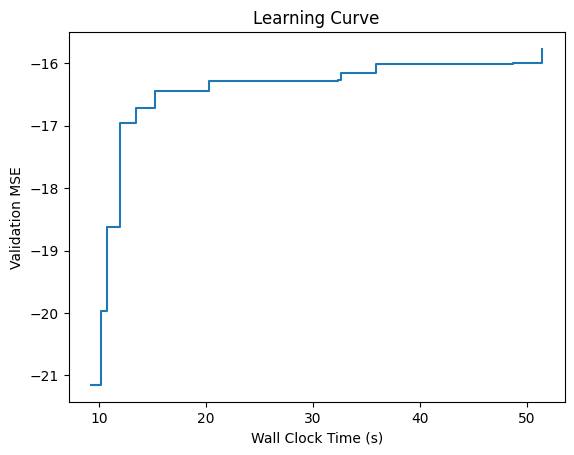

In [18]:
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history =get_output_from_log(filename='train_delays_regressor.log', time_budget=60)
plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation MSE')
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

# Saving the model

In [21]:
automl.model.estimator

LGBMRegressor(learning_rate=0.07936628267012258, max_bin=255,
              min_child_samples=24, n_estimators=1, n_jobs=-1, num_leaves=16,
              reg_alpha=0.49744183179244617, reg_lambda=0.1689067823740087,
              verbose=-1)

In [23]:
# Fit the model on training set
automl.model.estimator.fit(X_train, y_train)
# save the model to disk
filename = 'LGBMRegressor_MSE_on_test_18_23.sav'
pickle.dump(automl.model.estimator, open(filename, 'wb'))